In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
#statsmodels.tsa.holtwinters.ExponentialSmoothing
sns.set_style('darkgrid')
%matplotlib inline

Importing plotly failed. Interactive plots will not work.


## Exploratory Data Analysis

In [2]:
complete_dataset = pd.read_csv('./../data/owid-covid-data.csv')

In [3]:
#complete_dataset.info()

In [4]:
interest_columns = ['location', 'date', 'new_cases', 'new_cases_smoothed']

In [5]:
dataset = complete_dataset[interest_columns].copy()
dataset = dataset.set_index('date')

In [6]:
# Filter only world data

cases = dataset[dataset['location'] == 'World']

<AxesSubplot:xlabel='date'>

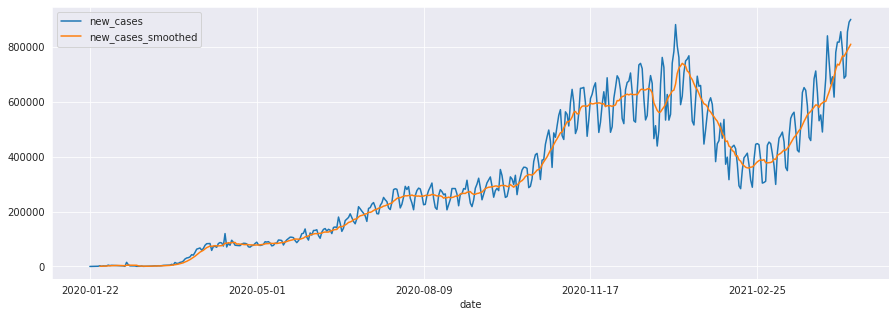

In [7]:
cases.plot(figsize=(15,5))

### Data Histogram

[]

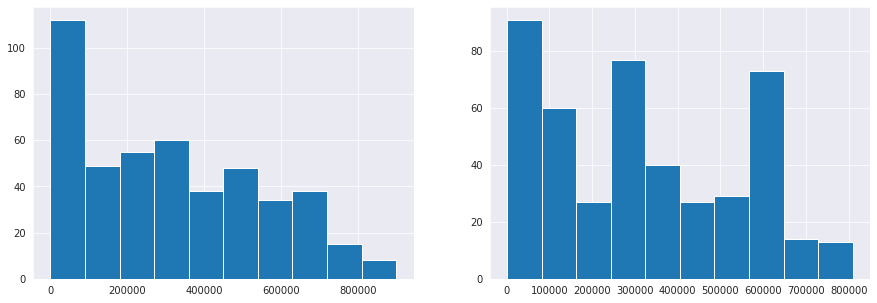

In [8]:
fig,(ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

ax1.hist(cases['new_cases'])
ax2.hist(cases['new_cases_smoothed'])

plt.plot()

## Forecast covid new cases

In [13]:
train_size = 400

### Auto ARIMA - `new_cases`

In [14]:
y = cases['new_cases']
train, test = train_test_split(y, train_size=train_size)

In [15]:
model = pm.auto_arima(train, seasonal=True, m=12)

In [18]:
forecasts = model.predict(20)

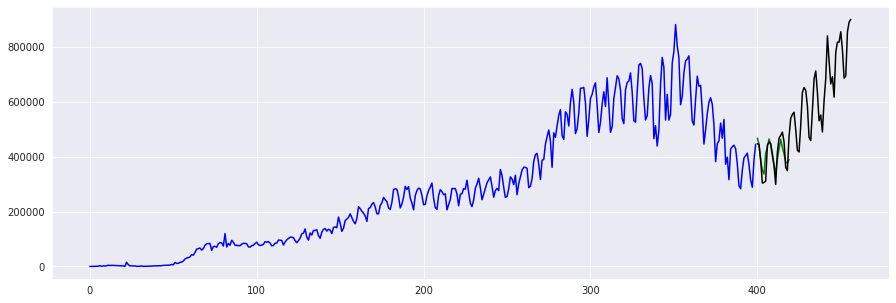

In [19]:
plt.figure(figsize=(15,5))
x = np.arange(y.shape[0])
f = np.arange(train_size + forecasts.shape[0])
plt.plot(x[:train_size], train, c='blue')
plt.plot(f[train_size:], forecasts, c='green')
plt.plot(x[train_size:], test, c='black')
plt.show()


In [24]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  400
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -3925.339
Date:                Sat, 24 Apr 2021   AIC                           7860.679
Time:                        10:17:54   BIC                           7880.624
Sample:                             0   HQIC                          7868.578
                                - 400                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0768      0.047     -1.643      0.100      -0.168       0.015
ar.L2          0.7961      0.049     16.378      0.000       0.701       0.891
ma.L1          0.5279      0.063      8.389      0.000       0.405       0.651
ma.L2         -0.2537      0.055     -4.609      0.000      -0.362      -0.146
sigma2      2.137e+07   2.34e-09   9.14e+15      0.000    2.14e+07    2.14e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):              1643.01
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):              31.06   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.63e+31. Standard errors may be unstable.
"""

In [30]:
print(F'SARIMAX Order: {model.order}')
print(F'SARIMAX Seasonal Order: {model.seasonal_order}')

SARIMAX Order: (2, 1, 2)
SARIMAX Seasonal Order: (0, 0, 0, 0)


In [ ]:
### Auto ARIMA - `new_cases_smoothed`

In [20]:
y = cases['new_cases_smoothed'].dropna()
train, test = train_test_split(y, train_size=train_size)

In [21]:
model = pm.auto_arima(train, seasonal=False, m=3)

/home/gabriel/forecast-covid/env/lib/python3.6/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (3) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


In [22]:
forecasts = model.predict(200)

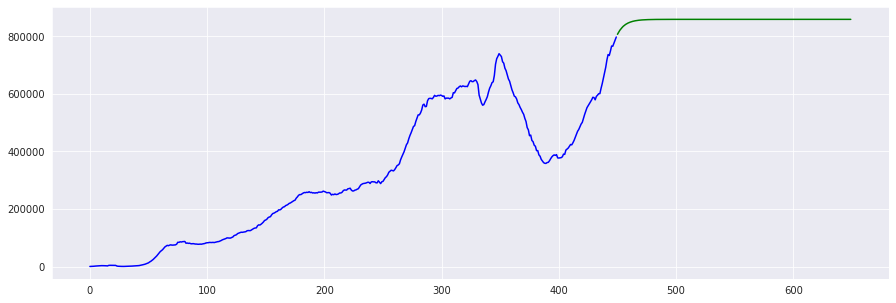

In [17]:
plt.figure(figsize=(15,5))
x = np.arange(y.shape[0])
f = np.arange(train_size + forecasts.shape[0])
plt.plot(x[:train_size], train, c='blue')
plt.plot(f[train_size:], forecasts, c='green')
plt.plot(x[train_size:], test, c='black')
plt.show()

### Prophet - `new_cases`

In [88]:
cases['ds'] = cases.index
cases['y'] = cases['new_cases'].copy()
df = cases[['ds', 'y']].reset_index(drop=True)

/home/gabriel/forecast-covid/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/gabriel/forecast-covid/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [104]:
df = df.loc[250:]

<AxesSubplot:>

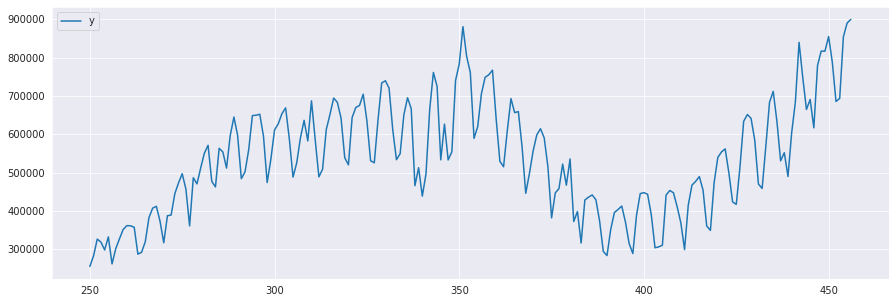

In [105]:
df.plot(figsize=(15,5))

In [106]:
model = Prophet()

In [107]:
model.fit(df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [108]:
future = model.make_future_dataframe(periods=100)
forecast = model.predict(future)
forecast = forecast.tail(100)['yhat_lower'].values

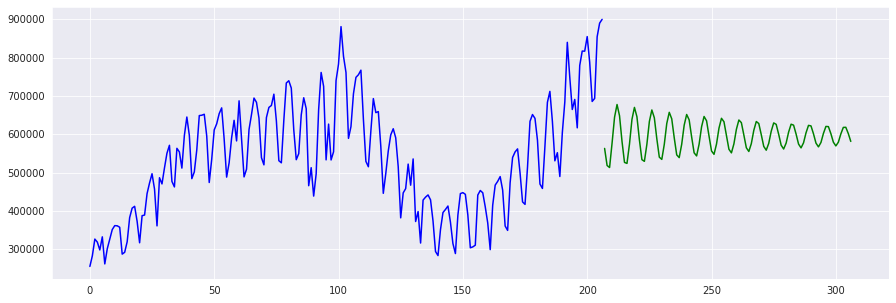

In [109]:
plt.figure(figsize=(15,5))
x = np.arange(df['y'].shape[0])
f = np.arange(df['y'].shape[0] + forecasts.shape[0])
plt.plot(x, df['y'], c='blue')
plt.plot(f[df['y'].shape[0]:], forecasts, c='green')
plt.show()